In [9]:
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
# ignore user warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
rmm2 = [float(l.split()[4]) for l in open('OMI_index.txt')]
rmm2 = np.array(rmm2)
rmm2 = -rmm2
rmm1 = [float(l.split()[5]) for l in open('OMI_index.txt')]
rmm1 = np.array(rmm1)

In [28]:
# Step 1: 
# assign initial PDF to data point
x_coordinate = -0.5
y_coordinate = -0.5
var          = multivariate_normal(mean=[x_coordinate,y_coordinate], cov=[[0.1,0],[0,0.1]])
rho_zero     = np.zeros(np.shape(rmm1))

for i in range(np.size(rmm1)):
    rho_zero[i] = var.pdf([rmm1[i],rmm2[i]])

# Step 2:
# creating checker 
xi = zi       = np.arange(-2,2.01,0.01)
xi,zi         = np.meshgrid(xi,zi)

# meshgrid to Cartesian coordinate 
# meshgrid back to grid_wise 
# these two steps help remove wiggle pattern 

# then integrate forward in time! 

t_total       = 47
rho           = np.zeros((np.size(rmm1[:-t_total,]),t_total))
rho[:,0]      = rho_zero[:-t_total,]

for t in range(t_total-1):
    if t>0:
        rho_tmp         = griddata((rmm1[t:-t_total+t],rmm2[t:-t_total+t]),rho[:,t],(xi,zi),method='linear')
        rho_tmp         = gaussian_filter(rho_tmp, sigma=20)
        rho[:,t]        = griddata((xi.flatten(),zi.flatten()), rho_tmp.flatten(), (rmm1[t:-t_total+t], rmm2[t:-t_total+t]), method='nearest')
    #det       = griddata((xi.flatten(),zi.flatten()), probability_ref.flatten(), (rmm1[t:13514-t_total+t], rmm2[t:13514-t_total+t]), method='nearest')
    #det_SINDy = griddata((xi.flatten(),zi.flatten()), new_probability_class.flatten(), (rmm1[t:13514-t_total+t], rmm2[t:13514-t_total+t]), method='nearest')
    rho[:,t+1]        = rho[:,t] #*(1-det_SINDy*0.05)
    rho[:,t+1]        = rho[:,t+1]/np.nansum(rho[:,t+1])



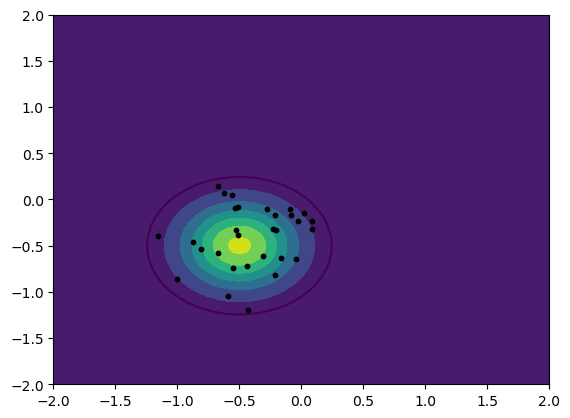

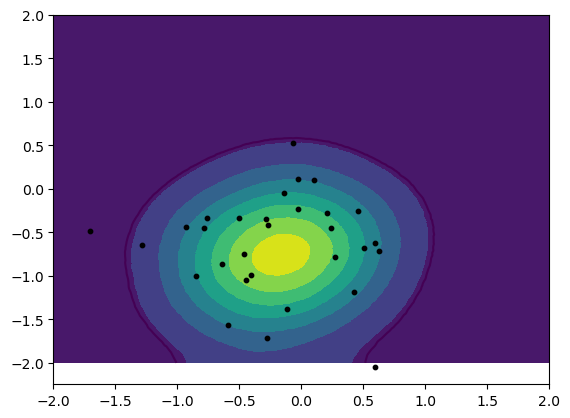

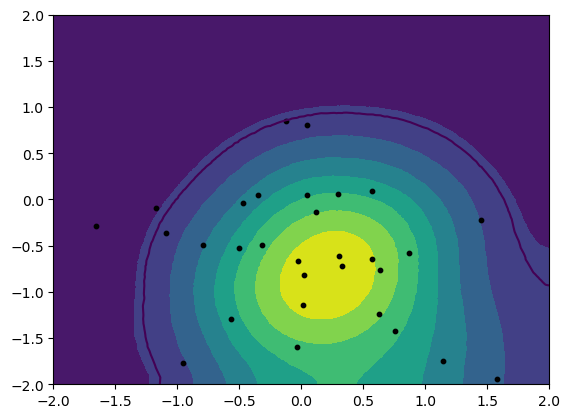

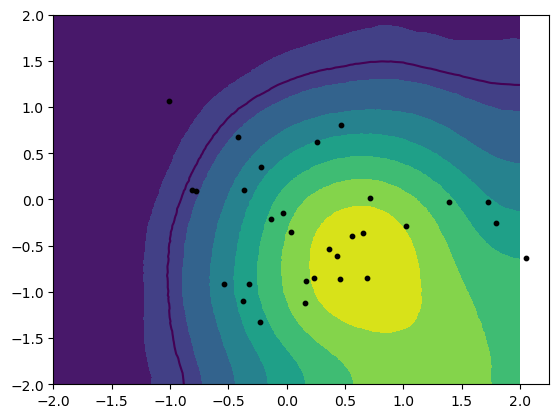

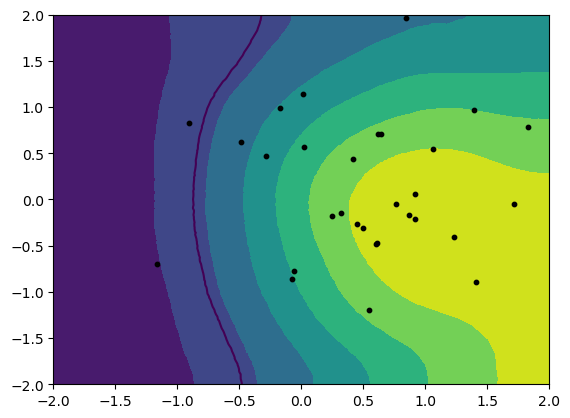

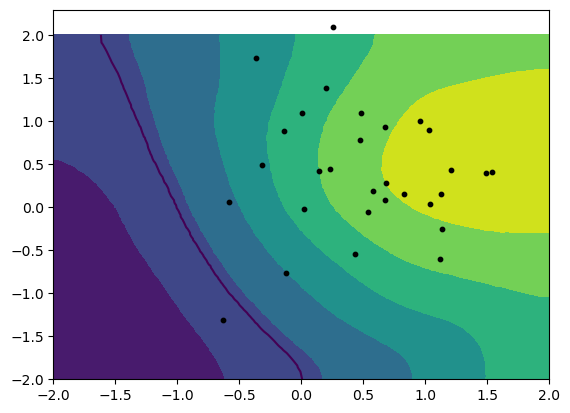

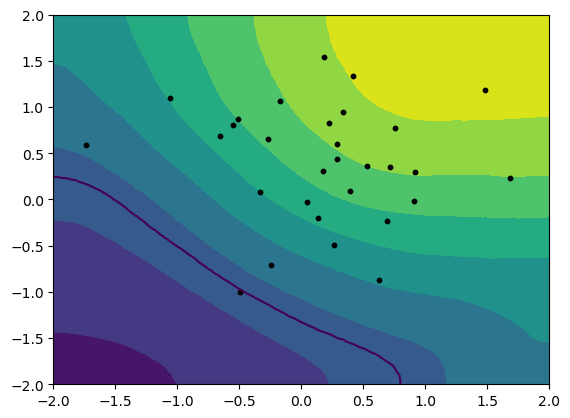

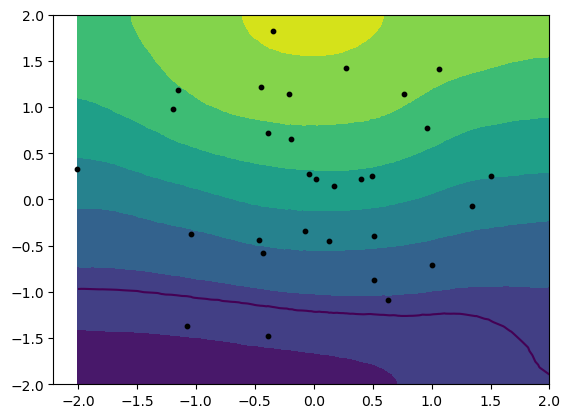

In [44]:
# calculating 95% confidence interval 

def find_CI(rho):
    global CI, posi
    for i in range(100):
        value_1     = np.percentile(rho/np.sum(rho),100-i-1)
        value_2     = np.percentile(rho/np.sum(rho),100-i)
        posi_1      = np.where((rho/np.sum(rho))>value_1)
        posi_2      = np.where((rho/np.sum(rho))>value_2)
        threshold_1 = np.sum((rho/np.sum(rho))[posi_1])
        threshold_2 = np.sum((rho/np.sum(rho))[posi_2])
        if (threshold_1-0.95)*(threshold_2-0.95)<0:
            posi    = posi_2
            indices = np.random.choice(range(len(posi_2[0])), replace=False, size=30)
            posi    = np.array(posi_2[0])[indices.astype(int)]
            CI      = value_2
    return CI, posi

for t in range(0,40,5):
    # model forecast
    rho_tmp = griddata((rmm1[t:-t_total+t],rmm2[t:-t_total+t]),rho[:,t],(xi,zi),method='linear')
    plt.figure()
    plt.contourf(xi,zi,rho_tmp/np.nansum(rho[:,t]))
    CI_95,posi_95 = find_CI(rho[:,t])
    plt.contour(xi,zi,rho_tmp/np.nansum(rho[:,t]),levels=[CI_95])

    # verification
    # if today the observation is independent of the forecast above 
    # we can first select some random points falling within the CI
    if t==0:
        rho_obs_grid          = griddata((xi.flatten(),zi.flatten()),(rho_tmp/np.nansum(rho[:,0])).flatten(),(rmm1[t:-t_total+t],rmm2[t:-t_total+t]),method='linear')
        rho_obs_Cartesian     = griddata((rmm1[t:-t_total+t], rmm2[t:-t_total+t]), rho_obs_grid,(xi.flatten(),zi.flatten()),method='nearest')
        CI_95_obs,posi_95_obs = find_CI(rho_obs_grid)
    plt.scatter((rmm1[t:-t_total+t])[posi_95_obs],(rmm2[t:-t_total+t])[posi_95_obs],s=10,color='k')